# Data Science Case Study: Demand Forecasting

### Step-by-Step Overview
**Understand the Business Context**: Predict demand for better inventory and supply chain planning. Analyze the dataset to identify key features like item categories, stores, and states, and understand how demand might be influenced by factors such as holidays, promotions, or seasonal trends. This ensures our solution aligns with the operational goals.

**Data Cleaning and Exploration**: Ensure the data is accurate and consistent by addressing missing values, outliers, or anomalies. Perform exploratory data analysis (EDA) to uncover patterns, trends, and seasonality in the sales data, which will guide the feature engineering and model-building process.

**Feature Engineering**: Create new variables that enhance the model’s predictive power, such as:

- Temporal Features: Day of the week, month, holiday flags.
- Categorization of months
- Event Indicators: Promotions or other business-related drivers. These features allow the model to better understand and replicate real-world demand fluctuations.


**Model Selection and Forecasting**: Use an AutolML frameworks (`TPOT`) to automate the fit and model selection tasks for the many models wee need: One for each combination of item and store. The models will predict sales for each item across the 28-day period.

**Forecast Evaluation**: Measure forecast accuracy using metrics like MAPE, RMSE and MASE. In the post-deployement phase it is necessary to monitor and refine the models using real-time data to adapt to changing trends.


In [1]:
! pip install tpot

  Using cached TPOT-0.12.2-py3-none-any.whl.metadata (2.0 kB)
  Using cached update_checker-0.18.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached stopit-1.1.2.tar.gz (18 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached TPOT-0.12.2-py3-none-any.whl (87 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ---------------------------------------- 11.2/11.2 MB 24.9 MB/s eta 0:00:00
Using cached update_checker-0.18.0-py3-none-any.whl (7.0 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=12064 sha256=f29403fc62731a60b5e471025d5485bb4cc8ebd35b1b058e888cd212cd869164
  Stored in directory: c:\users\usr\appdata\local\pip\cache\wheels\48\8c\93\3afb1916772591fe6bcc25cdf8b1c5bdc362f0ec8e2f0fd413
Successfully

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from tpot import TPOTRegressor

# ------------------------------------------------------------------- #
# -- Constants and parameters
# ------------------------------------------------------------------- #
MAIN_FOLDER = 'C:/Users/usr/projects/consultorias/job_tests/Shipbob-Kopius/DS-CaseStudy-SalesForecast/data/m5/datasets/'

# ------------------------------------------------------------------- #
# -- Auxiliar functions
# ------------------------------------------------------------------- #

# Function to preprocess data and split
def preprocess_data(input_df):

    # -- Convert 'month' to a categorical feature
    input_df['month'] = input_df['month'].astype(str)

    # --  One-hot encode categorical features (e.g., month, weekday, event_type_1, event_type_2)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    categorical_cols = ['month', 'weekday', 'event_type_1', 'event_type_2']
    categorical_data = encoder.fit_transform(input_df[categorical_cols])
    categorical_features = encoder.get_feature_names_out(categorical_cols)

    # --  Combine categorical and numerical features
    numerical_cols = ['wday', 'year', 'snap_CA', 'snap_TX', 'snap_WI']
    X = np.hstack([input_df[numerical_cols].values, categorical_data])
    y = input_df['sales'].values

    # --  Split data into train, validation, and test using 'split' column
    train_idx = input_df['split'] == 'train'
    val_idx = input_df['split'] == 'val'
    test_idx = input_df['split'] == 'test'

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    return X_train, y_train, X_val, y_val, X_test, y_test

# ------------------------------------------------------------------ #
# -- Functions to evaluate the model
# ------------------------------------------------------------------ #
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).

    Parameters:
    :param y_true: Actual values.
    :param y_pred : Predicted values.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_deviation(y_true, y_pred):
    """
    Calculate the Mean Absolute Deviation (MAD).

    Parameters:
    :param y_true: Actual values.
    :param y_pred : Predicted values.
    """
    return np.mean(np.abs(y_true - y_pred))


def evaluate_model(y_true, y_pred):
    """
    Evaluate model performance using multiple metrics.

    Parameters:
    :param y_true: Actual values.
    :param y_pred: Predicted values.

    Returns:
    :return:
    A dictionary containing:
        - MAE: Mean Absolute Error
        - MSE: Mean Squared Error
        - RMSE: Root Mean Squared Error
        - R2: Coefficient of Determination
        - MAPE: Mean absolute percentage error
        - MAD': Mean absolute deviation
    """

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    MAD = mean_absolute_deviation(y_true, y_pred)

    return {
        'MAE': mae
        , 'MSE': mse
        , 'RMSE': rmse
        , 'R2': r2
        , 'MAPE': MAPE
        , 'MAD': MAD
    }


C:\Users\usr\miniconda3\envs\ship\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


## Get Data
Here I load the sample data preprocessed in `R` using the script `walmart_case_study_notbook.Rmd`.


In [5]:
# -------------------------------------------- #
# Get data
# -------------------------------------------- #

df = pd.read_csv(MAIN_FOLDER + 'sample_demand_da.csv')

# Initialize results storage
results = []
predictions = []
unique_items = df['item_id'].unique()
unique_stores = df['store_id'].unique()


C:\Users\usr\AppData\Local\Temp/ipykernel_6540/576571820.py:5: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(MAIN_FOLDER + 'sample_demand_da.csv')


## Fit models
We need a separate model for each unique combination of item and store. The script iterates through these combinations, performs feature engineering, and uses TPOT to build a customized model tailored to the specific dataset for each case.


In [9]:
# -- Loop through each item and store combination
i_item = -1
while i_item < len(unique_items)-1:
    i_item = i_item + 1
    i_store = -1
    while i_store < len(unique_stores)-1:
        i_store = i_store + 1

        item = unique_items[i_item]
        store = unique_stores[i_store]
        print(f"Fitting model for Item: {item}, Store: {store}.")

        item_store_df = df[
            (df['item_id'] == item ) &
            (df['store_id'] == store)
        ]
        # -- Preprocess data
        X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(item_store_df)

        # ------------------------------------------------------------ #
        # -- Set tpot model
        # ------------------------------------------------------------ #
        tpot = TPOTRegressor( generations=5, population_size=2, random_state=42, cv=5, verbosity=1)
        #tpot = TPOTRegressor( generations=5, population_size=10, random_state=42, cv=5, verbosity=2)

        # -- Train the TPOT model
        tpot.fit(X_train, y_train)

        # -- Save model as a string to be used in other trials
        model_str = str(tpot.fitted_pipeline_)

        # -- Make predictions on validation set
        y_val_pred = tpot.predict(X_val)

        # -- Evaluate model performance
        metrics = evaluate_model(y_val, y_val_pred)

        # -- Append results
        results.append({
            'item_id': item
            , 'store_id': store
            , 'model': model_str
            
            , 'MAE': metrics['MAE']
            , 'MSE': metrics['MSE']
            , 'RMSE': metrics['RMSE']
            , 'R2': metrics['R2']
            , 'MAPE': metrics['MAPE']
            , 'MAD': metrics['MAD']
        })

        X_all = np.concatenate([X_train, X_val, X_test], axis=0)
        y_all_pred = tpot.predict(X_all)

        item_store_df['pred'] = y_all_pred

        predictions.append(item_store_df)


# Convert results to a DataFrame and save
results_df = pd.DataFrame(results)
#results_df.to_csv(MAIN_FOLDER+'model_results.csv', index=False)
print("Model fitting and evaluation completed.")



C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['month'] = input_df['month'].astype(str)
C:\Users\usr\miniconda3\envs\ship\lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
C:\Users\usr\miniconda3\envs\ship\lib\site-packages\sklearn\base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


Fitting model for Item: HOBBIES_1_390, Store: CA_1.
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
Best pipeline: RandomForestRegressor(ElasticNetCV(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), 

C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:58: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2869353984.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_store_df['pred'] = y_all_pred
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['month'] = input_df['month'].astype(str)
C:\Users\usr\miniconda3\envs

Fitting model for Item: HOBBIES_1_390, Store: CA_2.
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
Best pipeline: ElasticNetCV(input_matrix, l1_ratio=0.30000000000000004, tol=0.0001)
Fitting model for Item: HOBBIES_1_390, Store: CA_3.
is

C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:58: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2869353984.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_store_df['pred'] = y_all_pred
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['month'] = input_df['month'].astype(str)
C:\Users\usr\miniconda3\envs


is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.05, min_samples_leaf=11, min_samples_split=9, n_estimators=100)
Fitting model for Item: HOBBIES_2_061, Store: CA_1.


C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:58: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2869353984.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_store_df['pred'] = y_all_pred
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['month'] = input_df['month'].astype(str)
C:\Users\usr\miniconda3\envs

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.05, min_samples_leaf=11, min_samples_split=9, n_estimators=100)
Fitting model for Item: HOBBIES_2_061, Store

C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:58: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2869353984.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_store_df['pred'] = y_all_pred
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['month'] = input_df['month'].astype(str)
C:\Users\usr\miniconda3\envs

is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=11, min_samples_split=9, n_estimators=100)


C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:58: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2869353984.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_store_df['pred'] = y_all_pred
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['month'] = input_df['month'].astype(str)
C:\Users\usr\miniconda3\envs

Fitting model for Item: HOBBIES_2_061, Store: CA_3.
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
Best pipeline: RandomForestRegressor(ElasticNetCV(Nystroem(input_matrix, gamma=0.30000000000000004, kernel=polynomial, n_components=2), l1

C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:58: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:58: RuntimeWarning: invalid value encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2869353984.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_store_df['pred'] = y_all_pred
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

Fitting model for Item: HOUSEHOLD_1_396, Store: CA_1.
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
Best pipeline: RandomForestRegressor(Nystroem(input_matrix, gamma=0.30000000000000004, kernel=polynomial, n_components=2), bootstrap=Tru

C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:58: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2869353984.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_store_df['pred'] = y_all_pred
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['month'] = input_df['month'].astype(str)
C:\Users\usr\miniconda3\envs

Fitting model for Item: HOUSEHOLD_1_396, Store: CA_2.
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
Best pipeline: RandomForestRegressor(ElasticNetCV(input_matrix, l1_ratio=0.75, tol=0.01), bootstrap=True, max_features=0.850000000000000

C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:58: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2869353984.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_store_df['pred'] = y_all_pred
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['month'] = input_df['month'].astype(str)
C:\Users\usr\miniconda3\envs

Fitting model for Item: HOUSEHOLD_1_396, Store: CA_3.
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
Best pipeline: RandomForestRegressor(ElasticNetCV(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False)

C:\Users\usr\AppData\Local\Temp/ipykernel_6540/3942908188.py:58: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2869353984.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_store_df['pred'] = y_all_pred


In [10]:
predictions_df = pd.concat(predictions)

In [11]:
predictions_df

,Unnamed: 0,item_id,dept_id,cat_id,store_id,state_id,day_index,sales,split,date,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,pred
0,1,HOBBIES_1_390,HOBBIES_1,HOBBIES,CA_1,CA,d_1,2,train,2011-01-29,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.650215
100,101,HOBBIES_1_390,HOBBIES_1,HOBBIES,CA_1,CA,d_2,1,train,2011-01-30,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.945623
200,201,HOBBIES_1_390,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,train,2011-01-31,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.434573
300,301,HOBBIES_1_390,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,train,2011-02-01,...,2,2011,NaN,NaN,NaN,NaN,1,1,0,0.434772
400,401,HOBBIES_1_390,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,train,2011-02-02,...,2,2011,NaN,NaN,NaN,NaN,1,0,1,0.397486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196422,196423,HOUSEHOLD_1_396,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,d_1965,1,test,2016-06-15,...,6,2016,NaN,NaN,NaN,NaN,0,1,1,1.364177
196522,196523,HOUSEHOLD_1_396,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,d_1966,0,test,2016-06-16,...,6,2016,NaN,NaN,NaN,NaN,0,0,0,1.123627
196622,196623,HOUSEHOLD_1_396,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,d_1967,1,test,2016-06-17,...,6,2016,NaN,NaN,NaN,NaN,0,0,0,1.260790
196722,196723,HOUSEHOLD_1_396,HOUSEHOLD_1,HOUSEHOLD,CA_3,CA,d_1968,1,test,2016-06-18,...,6,2016,NaN,NaN,NaN,NaN,0,0,0,1.815071


In [30]:
import matplotlib.pyplot as plt

def plot_time_series(data):
    """
    Plot cumulative time series data with sales and predictions, differentiated by split.

    Parameters:
    :param data: DataFrame containing 'date', 'sales', 'pred', and 'split' columns.

    Returns:
    None
    """
    plt.figure(figsize=(14, 8))

    data['cumulative_sales'] = data['sales'].cumsum()
    data['cumulative_pred'] = data['pred'].cumsum()

    # Filter by unique splits and plot each split separately
    splits = data['split'].unique()
    for split in splits:
        split_data = data[data['split'] == split].sort_values('date')

        # plt.plot(split_data['date'], split_data['cumulative_sales'], label=f'Cumulative Sales ({split})', linewidth=2)
        # plt.plot(split_data['date'], split_data['cumulative_pred'], linestyle='--', label=f'Cumulative Predictions ({split})', linewidth=2)
        plt.plot(split_data['date'], split_data['cumulative_sales'], label=f'Cumulative Sales ({split})', linewidth=2)

    plt.plot(data['date'], data['cumulative_pred'], linestyle='--', label=f'Prediction', linewidth=2)

    # Customizing the plot
    plt.title('Cumulative Time Series Plot of Sales and Predictions', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Values', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.xticks(rotation=45)
    #plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2010302981.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cumulative_sales'] = data['sales'].cumsum()
C:\Users\usr\AppData\Local\Temp/ipykernel_6540/2010302981.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cumulative_pred'] = data['pred'].cumsum()


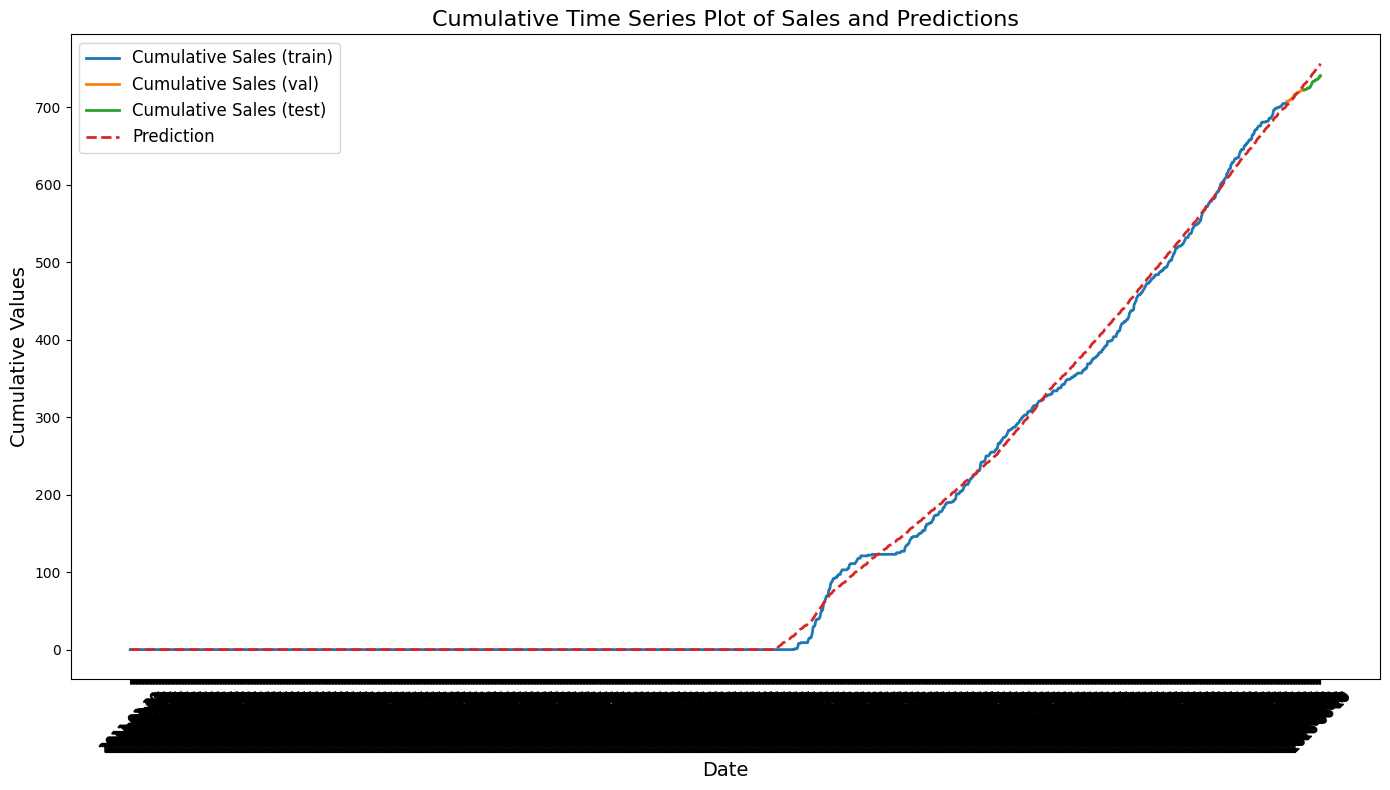

In [46]:
plot_time_series(predictions[7])

# Conclusion

The system was designed to create a tailored model for each item and store, automatically selecting the best model and predicting demand for the test data. To save time, this version focused on fewer stores and items and used a limited number of generations in the TPOTRegressor. Even with these constraints, the approach effectively tackled the challenge of demand forecasting.

#### Key Highlights:
- Scalable and Flexible: The system can be applied to more stores and items with minimal changes.
- Automation: TPOT eliminates manual effort by finding the best model automatically.
- Foundation for Improvement: The system is ready for enhancements and further development.

#### Next Steps:
- Train models for all stores and items.
- Add smarter features like trends, moving averages, and seasonal patterns to boost accuracy.
- Use backtesting to simulate performance and improve the training process.
- Optimize the time range of training data (looking too much to the past might decrease model accuracy).
- Allow `TPOT` to explore more options by increasing the number of generations.
- Parametrize tpot to use Neural Networks and models tailored for time series.
- Incorporate tools to explain predictions and help stakeholders trust the results.
- Use tools more suitible for graphical analysis.
